# English Seq-2-Seq Normalisation

In [12]:
import numpy as np
import tensorflow as tf
import keras
import os
import string

English

In [13]:
# Data_Path - May vary for user to user, so written separately

# Mounting drive for accessing data.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
data_path = f'/content/drive/MyDrive/NLP_Data/MultiLex_Norm/Multilexnorm Challenge/English/train.norm.txt'

Mounted at /content/drive


In [14]:
batch_size = 64  # Batch size for training.
epochs = 150  # Number of epochs to train for.
latent_dim = 68  # Latent dimensionality of the encoding space.
num_samples = 20000  # Number of samples to train on.

In [15]:
# Pre-Processor
def should_include_string(
    input_string : str,
    ):
    '''
    Returns a boolean that indicates whether we need
    to insert it in the text vocabulary or not.

    Args:
      input_string : (str) string to clean

    Returns:
      boolean
    '''
    # ' - this character might be important, retaining it
    filter_str = string.punctuation.replace("\'", "")

    new_string = input_string.translate(str.maketrans('', '', filter_str))

    if new_string == input_string:
        return True
    return False

Character encoding

In [16]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

for line in lines[: min(num_samples, len(lines) - 1)]:
  if line=='\n':
    continue
  else:
    input_text, target_text= line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    if(should_include_string(input_text)):
        target_text = "\t" + target_text + "\n"
        input_texts.append(input_text)
        target_texts.append(target_text)
        for char in input_text:
            if char not in input_characters:
                input_characters.add(char)
        for char in target_text:
            if char not in target_characters:
                target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 14525
Number of unique input tokens: 37
Number of unique output tokens: 40
Max sequence length for inputs: 21
Max sequence length for outputs: 39


encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.

decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.

decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

In [17]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

one hot rep

In [18]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    #encoder_input_data[i, t + 1 :, input_token_index[' ']] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[' ']] = 1.0
    decoder_target_data[i, t:, target_token_index[' ']] = 1.0

In [19]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [21]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.25,
    verbose = 2
)
# Save model
model.save("s2s")

Epoch 1/150
171/171 - 60s - loss: 0.0354 - accuracy: 0.9909 - val_loss: 0.0453 - val_accuracy: 0.9888
Epoch 2/150
171/171 - 1s - loss: 0.0342 - accuracy: 0.9911 - val_loss: 0.0664 - val_accuracy: 0.9831
Epoch 3/150
171/171 - 1s - loss: 0.0328 - accuracy: 0.9916 - val_loss: 0.0558 - val_accuracy: 0.9857
Epoch 4/150
171/171 - 1s - loss: 0.0321 - accuracy: 0.9920 - val_loss: 0.0503 - val_accuracy: 0.9874
Epoch 5/150
171/171 - 1s - loss: 0.0310 - accuracy: 0.9921 - val_loss: 0.0563 - val_accuracy: 0.9854
Epoch 6/150
171/171 - 1s - loss: 0.0306 - accuracy: 0.9921 - val_loss: 0.0505 - val_accuracy: 0.9875
Epoch 7/150
171/171 - 1s - loss: 0.0303 - accuracy: 0.9923 - val_loss: 0.0529 - val_accuracy: 0.9871
Epoch 8/150
171/171 - 1s - loss: 0.0290 - accuracy: 0.9927 - val_loss: 0.0549 - val_accuracy: 0.9859
Epoch 9/150
171/171 - 1s - loss: 0.0283 - accuracy: 0.9928 - val_loss: 0.0549 - val_accuracy: 0.9863
Epoch 10/150
171/171 - 1s - loss: 0.0277 - accuracy: 0.9928 - val_loss: 0.0501 - val_accur

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


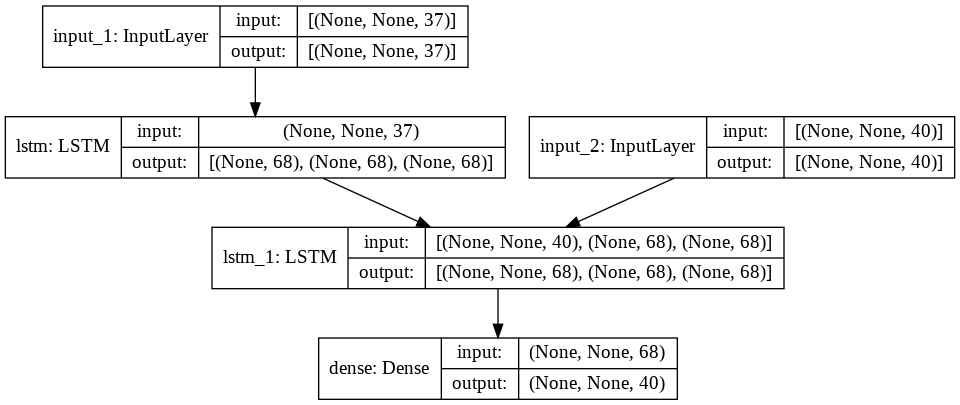

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

testing with validation

In [23]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_4")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_5")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [24]:
for seq_index in range(50):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: rt
Decoded sentence: rt

-
Input sentence: ah
Decoded sentence: ah

-
Input sentence: why
Decoded sentence: why

-
Input sentence: sub
Decoded sentence: sub

-
Input sentence: ozil
Decoded sentence: ozil

-
Input sentence: opolo
Decoded sentence: opolo

-
Input sentence: eyes
Decoded sentence: eyes

-
Input sentence: u
Decoded sentence: you

-
Input sentence: no
Decoded sentence: no

-
Input sentence: fit
Decoded sentence: fit

-
Input sentence: open
Decoded sentence: open

-
Input sentence: eyes
Decoded sentence: eyes

-
Input sentence: u
Decoded sentence: you

-
Input sentence: have
Decoded sentence: have

-
Input sentence: a
Decoded sentence: a

-
Input sentence: very
Decoded sentence: very

-
Input sentence: sexy
Decoded sentence: sexy

-
Input sentence: header
Decoded sentence: header

-
Input sentence: rawr
Decoded sentence: rawr

-
Input sentence: i
Decoded sentence: i

-
Input sentence: miss
Decoded sentence: miss

-
Input sentence: u
Decoded sentence: you

-


Testing with dev

In [31]:
test_data_path = '/content/drive/MyDrive/NLP_Data/MultiLex_Norm/Multilexnorm Challenge/English/dev.norm.txt'

In [38]:
f = open(test_data_path, 'r')
print(f.read()[:202])
f.close()

@cdutra5	@cdutra5
bruh	brother
get	get
out	out
yo	your
feelings	feelings
lol	lol

rt	rt
@demberel_s	@demberel_s
:	:
manan	manan
dund	dund
xaragdax	xaragdax
ter	ter
uuliin	uuliin
oroid	oroid
minii	minii



In [39]:
# Vectorize the data.
input_texts = []
#target_texts = []
input_characters = set()
#target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
for line in lines[: min(num_samples, len(lines) - 1)]:
  if line=='\n':
    continue
  else:
    input_text, target_text= line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    #target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    #target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    '''for char in target_text:
        if char not in target_characters:
            target_characters.add(char)'''

In [40]:
# input_texts

In [41]:
input_characters = sorted(list(input_characters))
num_encoder_tokens = len(input_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])

In [42]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

In [43]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    #encoder_input_data[i, t + 1 :, input_token_index[' ']] = 1.0

In [47]:
encoder_input_data.shape

(18755, 40, 67)

In [45]:
input_seq = encoder_input_data
print("-")
print("Input sentence:", input_texts[seq_index])
decoded_sentence = decode_sequence(input_seq)

print("Decoded sentence:", decoded_sentence)

-
Input sentence: swan


ValueError: ignored